## Political Corruption News Filtering Script

### Overview
This script processes a dataset of news articles to identify those related to political corruption. It applies multiple filtering steps based on keywords and text similarity using TF-IDF and cosine similarity. The final filtered dataset is saved for further analysis.
This is used to identify articles for the inductive analysis of frame identification. 
                                                                                                                                                                                                                                                     
### Steps

#### 1. **Load Data**
- The script reads a CSV file containing news articles.
- It prints the total number of articles in the original dataset.

#### 2. **Filter on Keywords**
- The function `is_political_corruption()` determines whether an article contains both political and corruption-related terms.
- If an article meets these criteria, it is marked as relevant (`is_political_corruption = True`).
- The dataset is filtered to keep only relevant articles.

#### 3. **TF-IDF Similarity Filter**
- A predefined set of reference texts containing political corruption phrases is used.
- The TF-IDF (Term Frequency-Inverse Document Frequency) method is applied to transform the articles and reference texts into numerical vectors.
- Cosine similarity is calculated between each article and the reference texts.
- Articles with a similarity score above 0.1 are retained.

#### 4. **Export Filtered Data**
- The final filtered dataset is saved as both a CSV and an Excel file.

#### 5. **Stratified Date Sample**
- The script ensures that the `date` column is properly formatted.
- It performs stratified sampling, selecting a limited number of articles per unique date.
- The sampled dataset is saved as an Excel file.

### Enhancements & Multi-Country Extension
- **Expanded Keyword Lists**: The script is extended to filter articles from Italy, Bulgaria, and the UK, in addition to the Netherlands.
- **Improved TF-IDF Filtering**: The similarity threshold and reference texts can be fine-tuned for better precision.
- **Organized Output Structure**: Filtered results are stored in a dedicated folder (`relevant_data`) with country-specific filenames.

### Output
- `relevant_data/filtered_Netherlands.csv`
- `relevant_data/filtered_Italy.csv`
- `relevant_data/filtered_Bulgaria.csv`
- `relevant_data/filtered_UK.csv`
- `relevant_data/sample_Netherlands.xlsx`
- `relevant_data/sample_Italy.xlsx`
- `relevant_data/sample_Bulgaria.xlsx`
- `relevant_data/sample_UK.xlsx`



In [40]:
import pandas as pd
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# ========== CONFIGURATION ==========

DATASETS = {
    "Netherlands": "../data/volume_2/Netherlands_news.csv",
    "United_Kingdom": "../data/volume_2/United_Kingdom_news.csv",
    "Bulgaria": "../data/volume_2/Bulgaria_news.csv",
    "Italy": "../data/volume_2/Italy_news.csv"
}

OUTPUT_FOLDER = "../data/volume_2/FILTERED_SAMPLES/"
OUTLET_SELECTION_FOLDER = "data/selected_outlets/"

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# ========== COUNTRY-SPECIFIC TERMS ==========
country_terms = {
    "Netherlands": {
        "political": [
            "politieke partij", "minister", "kabinet", "regering", "parlement",
            "staatscorruptie", "partijfinanciering", "burgemeester", "wethouder",
            "president", "dictator", "politieke leider", "stemfraude", "verkiezingsfraude",
            "wetgevende macht", "politiek schandaal", "overheidscontracten", "ambtsmisbruik"
        ],
        "corruption": [
            "omkoping", "belangenverstrengeling", "nepotisme", "machtsmisbruik",
            "staatsfraude", "stemfraude", "corruptie binnen overheid", "ministeriële omkoping",
            "partijfinanciering", "politieke afpersing", "parlementaire fraude",
            "regeringsfraude", "wangedrag", "witwassen", "steekpenningen", "vriendjespolitiek"
        ]
    },
    "Italy": {
        "political": [
            "partito politico", "ministro", "governo", "parlamento", "presidente",
            "leader politico", "elezioni", "scandalo politico", "corruzione di stato"
        ],
        "corruption": [
            "corruzione", "tangenti", "frode", "abuso di potere", "clientelismo",
            "finanziamento illecito", "lavaggio di denaro", "appropriazione indebita"
        ]
    },
    "Bulgaria": {
        "political": [
            "политическа партия", "министър", "правителство", "парламент",
            "кмет", "президент", "политически лидер", "избори",
            "законодателна власт", "политически скандал", "народен представител"
        ],
        "corruption": [
            "корупция", "подкуп", "измама", "злоупотреба с власт", "непотизъм",
            "шуробаджанащина", "пране на пари", "конфликт на интереси",
            "клиентелизъм", "финансиране на партия", "присвояване"
        ]
    },
    "United_Kingdom": {
        "political": [
            "political party", "minister", "cabinet", "government", "parliament",
            "mayor", "prime minister", "elections", "political scandal"
        ],
        "corruption": [
            "corruption", "bribery", "fraud", "influence peddling", "abuse of power",
            "cronyism", "money laundering", "conflict of interest", "embezzlement"
        ]
    }
}

reference_texts = {
    "Netherlands": [
        "politieke corruptie omkoping fraude belangenverstrengeling machtsmisbruik",
        "corruptie binnen de overheid, ministeriële omkoping, partijfinanciering schandalen",
        "staatsfraude, verkiezingsfraude, corruptie binnen politieke partijen",
        "politiek schandaal, stemfraude, vriendjespolitiek in de regering"
    ],
    "Italy": [
        "corruzione, frode, abuso di potere, clientelismo, scandalo politico, appropriazione indebita, tangenti",
        "finanziamento illecito ai partiti, lavaggio di denaro, scandali politici",
        "corruzione governativa, nepotismo, abuso d'ufficio"
    ],
    "Bulgaria": [
        "corruption, bribery, fraud, abuse of power, political scandal, money laundering",
        "nepotism, cronyism, party financing, election fraud",
        "embezzlement, misuse of public funds, political misconduct",
        "conflict of interest, corruption in parliament, political influence"
    ],
    "United_Kingdom": [
        "corruption, bribery, fraud, influence peddling, political scandal, abuse of power, collusion",
        "misuse of public office, parliamentary fraud, party donations scandal",
        "conflict of interest, cronyism, lobbying corruption"
    ]
}

# ========== LOAD OUTLET SELECTIONS ==========
selected_outlets = {}
for country in DATASETS:
    outlet_file = os.path.join(OUTLET_SELECTION_FOLDER, f"{country}_outlets_selection.txt")
    if os.path.exists(outlet_file):
        with open(outlet_file, encoding="utf-8") as f:
            outlets = {line.strip().lower() for line in f if line.strip()}
        selected_outlets[country] = outlets
    else:
        print(f"⚠️ Warning: No outlet selection file found for {country}. Skipping outlet filtering.")
        selected_outlets[country] = None

# ========== FILTER FUNCTION ==========
def is_political_corruption(text, political_terms, corruption_terms):
    text = text.lower()
    has_political = any(term in text for term in political_terms)
    has_corruption = any(term in text for term in corruption_terms)
    return has_political and has_corruption

# ========== PROCESS DATASETS ==========
for country, file_path in DATASETS.items():
    if not os.path.exists(file_path):
        print(f"Skipping {country}: File not found.")
        continue

    df = pd.read_csv(file_path)
    print(f"\nProcessing {country}: {len(df)} articles")

    # Outlet filtering
    if selected_outlets[country]:
        df["source.uri"] = df["source.uri"].astype(str).str.strip().str.lower()
        df = df[df["source.uri"].isin(selected_outlets[country])]
        print(f"📰 {country}: {len(df)} articles after outlet filtering")

    political_terms = country_terms[country]["political"]
    corruption_terms = country_terms[country]["corruption"]

    df[f"is_political_corruption_{country}"] = df["body"].astype(str).apply(
        lambda x: is_political_corruption(x, political_terms, corruption_terms)
    )

    filtered_df = df[df[f"is_political_corruption_{country}"]].copy()

    # TF-IDF Filtering
    vectorizer = TfidfVectorizer(max_features=5000, token_pattern=r"(?u)\b\w+\b")
    tfidf_matrix = vectorizer.fit_transform(filtered_df["body"])
    reference_vec = vectorizer.transform(reference_texts[country])

    similarity_scores = cosine_similarity(tfidf_matrix, reference_vec).max(axis=1)
    filtered_df["similarity"] = similarity_scores
    final_df = filtered_df[filtered_df["similarity"] > 0.1].drop_duplicates(subset=["body"])

    print(f"✅ {country}: {len(final_df)} articles after similarity filtering")

    # Save full filtered articles
    final_df.to_csv(os.path.join(OUTPUT_FOLDER, f"filtered_{country}.csv"), index=False)
    final_df.to_excel(os.path.join(OUTPUT_FOLDER, f"filtered_{country}.xlsx"), index=False)

    # Stratified sampling
    final_df["dateTime"] = pd.to_datetime(final_df["dateTime"], errors='coerce').dt.tz_localize(None)
    final_df["month"] = final_df["dateTime"].dt.to_period("M")

    monthly_sampled = final_df.groupby("month", group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), 3), random_state=42)
    ).reset_index(drop=True)

    sample_df = monthly_sampled.sample(n=min(len(monthly_sampled), 30), random_state=42)
    sample_df.to_excel(os.path.join(OUTPUT_FOLDER, f"sampled_{country}.xlsx"), index=False)

    print(f"📦 {country}: Sample saved with {len(sample_df)} articles")


Processing Netherlands: 121188 articles
📰 Netherlands: 67800 articles after outlet filtering
✅ Netherlands: 940 articles after similarity filtering
📦 Netherlands: Sample saved with 30 articles


/tmp/ipykernel_3435127/2087179700.py:120: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)



Processing United_Kingdom: 1039569 articles
📰 United_Kingdom: 748704 articles after outlet filtering
✅ United_Kingdom: 4530 articles after similarity filtering
📦 United_Kingdom: Sample saved with 30 articles


/tmp/ipykernel_3435127/2087179700.py:120: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)



Processing Bulgaria: 260300 articles
📰 Bulgaria: 235330 articles after outlet filtering
✅ Bulgaria: 155 articles after similarity filtering
📦 Bulgaria: Sample saved with 30 articles


/tmp/ipykernel_3435127/2087179700.py:120: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)



Processing Italy: 910942 articles
📰 Italy: 706025 articles after outlet filtering
✅ Italy: 4418 articles after similarity filtering
📦 Italy: Sample saved with 30 articles


0


/tmp/ipykernel_3435127/4257147320.py:34: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_df['year_month'] = combined_df['dateTime'].dt.to_period('M')


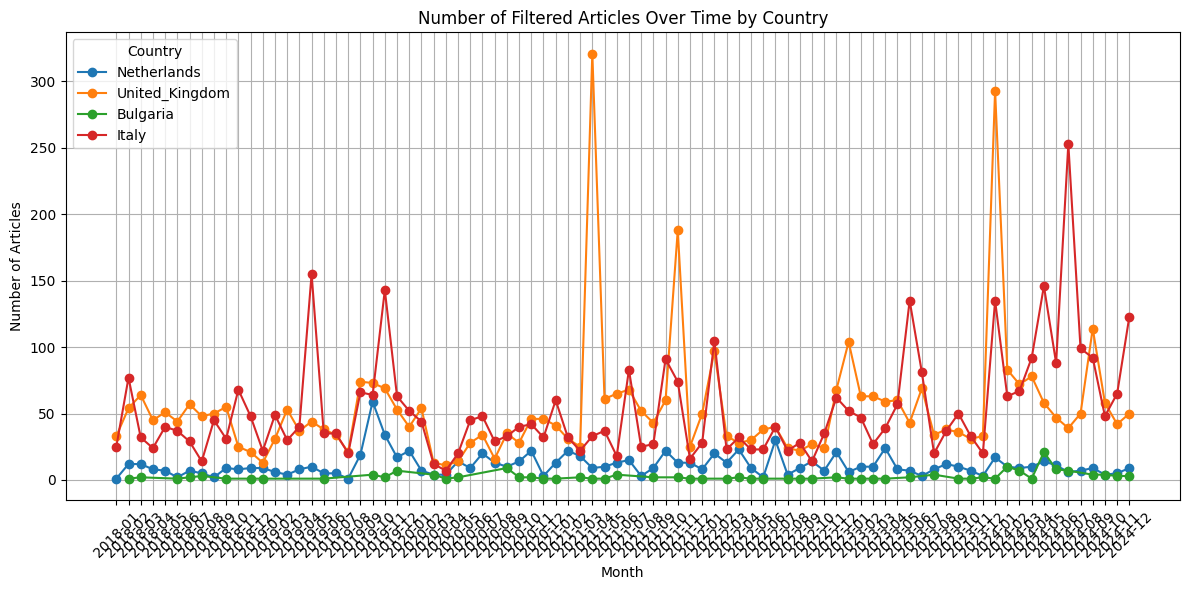

In [48]:
# List of countries you're working with
countries = ["Netherlands", "United_Kingdom", "Bulgaria", "Italy"]

# Empty list to store the data from each country
combined_df_list = []

# Iterate through all countries and load the filtered data for each one
for country in countries:
    final_file_path = os.path.join(OUTPUT_FOLDER, f"filtered_{country}.csv")
    
    # Check if the file exists before trying to load it
    if os.path.exists(final_file_path):
        # Load the filtered DataFrame
        country_df = pd.read_csv(final_file_path)
        
        # Add a new column to specify the country
        country_df['country'] = country
        
        # Append the DataFrame to the list
        combined_df_list.append(country_df)
    else:
        print(f"⚠️ {country}: No filtered data file found.")

# Combine all the data into one DataFrame
combined_df = pd.concat(combined_df_list, ignore_index=True)

# Display the first few rows of the combined DataFrame to verify
combined_df.head()
# Convert 'dateTime' to a proper datetime format
combined_df['dateTime'] = pd.to_datetime(combined_df['dateTime'], errors='coerce')
# Ensure no NaT values are present after conversion
print(combined_df['dateTime'].isnull().sum())  # Check for any missing dates
# Extract month and year for time-based grouping
combined_df['year_month'] = combined_df['dateTime'].dt.to_period('M')
# Group by 'year_month' and 'country' to count the articles per country over time
monthly_counts = combined_df.groupby(['year_month', 'country']).size().reset_index(name='article_count')

# Create a time-series plot for articles per country
plt.figure(figsize=(12, 6))

# Loop through the countries and plot their monthly article counts
for country in combined_df['country'].unique():
    country_data = monthly_counts[monthly_counts['country'] == country]
    plt.plot(country_data['year_month'].astype(str), country_data['article_count'], marker='o', label=country)

# Customize the plot
plt.title('Number of Filtered Articles Over Time by Country')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.legend(title='Country')
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


## Helper Function to Extract the Outlets
### Overview
This section of the code is responsible for extracting and saving the unique outlets (news sources) from the original datasets of various countries. The goal is to gather the list of national and regional news outlets that will be used in subsequent analyses. These outlets are saved to `.txt` files for easy reference.

### Workflow
1. **Load the Original Datasets:** 
   - The function iterates through the `DATASETS` dictionary, which contains the paths to the original datasets for each country.
   - If a dataset file is missing, the code skips processing that country and prints a message indicating the missing file.

2. **Extract Outlets:**
   - For each country, the code attempts to access the `source.uri` column (or the appropriate column containing the outlet names) from the dataset.
   - It checks if the `source.uri` column exists to ensure that the correct data is available.
   - The code then extracts the unique outlets from this column while discarding any `NaN` values. This creates a clean list of outlets.

3. **Save the Outlets:**
   - The unique outlets are written to a `.txt` file for each country. 
   - Each outlet is saved on a separate line in the file. The output files are stored in the `OUTPUT_FOLDER`, with the filename format being `{country}_outlets.txt`.

4. **Output and Logging:**
   - After processing each country, a success message is printed, showing the path where the outlets were saved.
   - If the `source.uri` column is missing in a dataset, an error message is printed to indicate this issue.

In [ ]:

# ========== LOAD ORIGINAL DATASETS AND SAVE OUTLETS TO .TXT FILES ==========
for country, file_path in DATASETS.items():
    if not os.path.exists(file_path):
        print(f"Skipping {country}: Original file not found.")
        continue
    
    # Load the original dataset
    df = pd.read_csv(file_path)
    
    # Check if 'source.uri' column exists (or adjust to the actual name of the column)
    if 'source.uri' in df.columns:
        # Get the unique set of outlets (ignoring any NaN values)
        outlets = set(df['source.uri'].dropna().unique())
        
        # Define the output file path for each country
        output_file_path = os.path.join(OUTPUT_FOLDER, f"{country}_outlets.txt")
        
        # Write the set of outlets to a text file
        with open(output_file_path, 'w') as file:
            for outlet in outlets: 
                file.write(f"{outlet}\n")
        
        print(f"✅ Outlets for {country} saved to {output_file_path}")
    else:
        print(f"Outlets column not found in {country} dataset.")
